# strain_tools simple example

# Introduction

We will calculate strain rates across a region of the West Greenland Ice Sheet from Store Glacier to Perlefiup Sermia. These data and region of interest are the same as that of Chudley _et al._ (2021). The _vx_ and _vy_ fields provided are 2018 annual velocity fields from the _MEaSUREs Greenland Annual Ice Sheet Velocity Mosaics from SAR and Landsat_ dataset, available from the National Snow and Ice Data Centre (https://doi.org/10.5067/OBXCG75U7540; Joughin, 2010). 

> Chudley _et al._ (2021). Controls on water storage and drainage in crevasses on the Greenland Ice Sheet. _Journal of Geophysical Research: Earth Surface_, _126_, e2021JF006287. https://doi.org/10.1029/2021JF006287

> Joughin (2010). Greenland Flow Variability from Ice-Sheet-Wide Velocity Mapping. _Journal of Glaciology_. _56_. 415-430. https://doi.org/10.3189/002214310792447734


## Housekeeping

Load modules:

In [1]:

import numpy as np
import rioxarray as rxr
import matplotlib.pyplot as plt

import strain_tools


Sort display options for MacBook:

In [2]:
%config InlineBackend.figure_format = 'retina'

## Load and clean velocity fields

Load velocity fields with rioxarray. `strain_tools` functions will accept (rio)xarray Dataarrays or vanilla numpy arrays, and will return like-for-like.

In [3]:

vx_fpath = "data/vel2018_vx.tif"
vy_fpath = "data/vel2018_vy.tif"

vx = rxr.open_rasterio(vx_fpath).squeeze(drop=True)
vy = rxr.open_rasterio(vy_fpath).squeeze(drop=True)


We can easily visualise the velocity fields using matplotlib and xarray, which work nicely together. 

Note that matplot streamplots require 'strictly increasing' y coordinates, which doesn't mesh with geospatial datasets that have their origin in the top-left rather than bottom-left. We can resolve this using the xarray `reindex()` or numpy `flipud()` functions (thanks to Tim Bartholomaus for the tip).

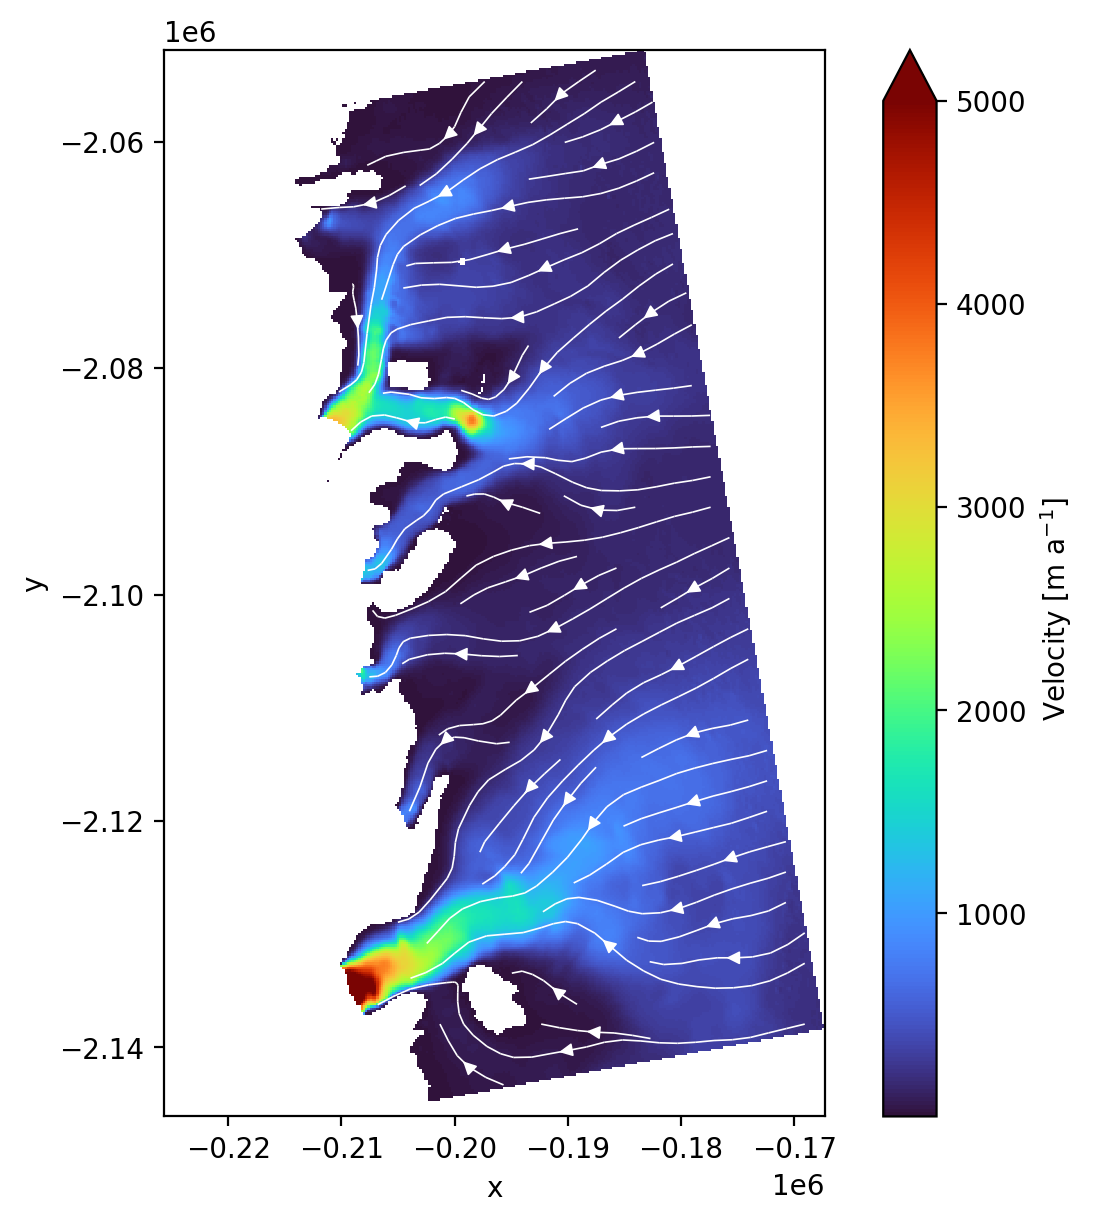

In [4]:

# Get absolute velocity
vv = np.sqrt(vx**2 + vy**2)

# Plot velocity with imshow
fig, ax = plt.subplots(figsize=(6,6), layout='constrained')

# Plot velocity field colourmap
vv.plot(ax=ax, cmap="turbo", vmax=5000, cbar_kwargs={'label':'Velocity [m a$^{-1}$]'})

# # Account for 'strictly increasing' requirement for streamplots in newer matplotlibs:
# # flip if Y is decreasing rather than increasing. This is only necessary for plotting
# streamplots, not quiverplots.
if vv.y.values[1] - vv.y.values[0] < 0:
    vv_flip = vv.reindex(y = vv.y[::-1])
    vx_flip = vx.reindex(y = vx.y[::-1])
    vy_flip = vy.reindex(y = vy.y[::-1])
else: 
    vv_flip = vv
    vx_flip = vx
    vy_flip = vy


# # Plot flow direction using streamplot
plt.streamplot(
    vv_flip.x.values, 
    vv_flip.y.values, 
    vx_flip.values, 
    vy_flip.values,
    color='white',
    linewidth=0.6,
    density=1.2,
)

ax.ticklabel_format(scilimits=(6,6))
ax.set_title(None)
ax.set_aspect('equal')


## Calculate log strain rates

Now, we can set our pixel resolution and desired length scale, before using the `log_strain_rates` function to extract our $\dot{\epsilon}_{xx}$, $\dot{\epsilon}_{yy}$, and $\dot{\epsilon}_{xy}$ values.

In [5]:
resolution = 200    # metres
length_scale = 750  # metres

In [6]:
log_strain_rates = strain_tools.log_strain_rates(vx, vy, resolution, length_scale, tol=10e-4, ydir=1)

Note the two additional default variables, which I have made explicit here. The `tol` variable (tolerance for the addaptive time-stepping scheme, from Alley _et al._ 2018). This default should be adequate for most applications. The `ydir` variable is set to 1 when the positive y direction is upscreen, and -1 when the positive y direction is downscreen. Here, it is 1. When xarray DataArrays are used, this is double-checked and a warning is raised if it could be wrong.

As we provided (rio)xarray DataArrays, the function has returned the log strain rates to us as an xarray Dataset:

In [7]:
log_strain_rates

<xarray.Dataset>
Dimensions:      (x: 292, y: 471)
Coordinates:
  * x            (x) float64 -2.256e+05 -2.254e+05 ... -1.676e+05 -1.674e+05
  * y            (y) float64 -2.052e+06 -2.052e+06 ... -2.146e+06 -2.146e+06
    spatial_ref  int64 0
Data variables:
    e_xx         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    e_yy         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    e_xy         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

If we had provided numpy arrays, it would have returned a tuple of numpy arrays `(e_xx, e_yy, e_xy)`.

From our logarithmic strain rates, we can calculate our principal strain rates following Chudley _et al._ (2021).

In [8]:
principal_strain_rates = strain_tools.principal_strain_rate_directions(
    log_strain_rates.e_xx, log_strain_rates.e_yy, log_strain_rates.e_xy
)

This method provides the first and second principal strain rates (`e_1` and `e_2`), but also the $U$ and $V$ components of the principal strain rates (`e_1U`, `e_1V`, `e_2U`, `e_2V`), which allow for the principal strain rate directions to be derived/plotted.

In [9]:
principal_strain_rates

<xarray.Dataset>
Dimensions:      (x: 292, y: 471)
Coordinates:
  * x            (x) float64 -2.256e+05 -2.254e+05 ... -1.676e+05 -1.674e+05
  * y            (y) float64 -2.052e+06 -2.052e+06 ... -2.146e+06 -2.146e+06
    spatial_ref  int64 0
Data variables:
    e_1          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    e_1U         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    e_1V         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    e_2          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    e_2U         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    e_2V         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

There is a slightly less computationally intensive approach also included within the package (`principal_strain_rate_magnitudes()`), which instead follows the method outlined by Nye (1959) and Harper _et al._ (1998). This approach does not include the horizontal/vertical components of the strain rates, only the values (i.e. only eigenvalues are calculated, not eigenvectors).

In [10]:
principal_strain_rates_alt = strain_tools.principal_strain_rate_magnitudes(
    log_strain_rates.e_xx, log_strain_rates.e_yy, log_strain_rates.e_xy
)

As the difference between these two approaches are minimal (see cell below), it may be worth using the alternative method for large-scale calculations where you may not be interested in the principal strain rate directions.

In [11]:
# Difference between two methods used to calculate principal strain rates are minimal - 
# related to different numpy methods, floating points, etc.

print('Mean differences between the two approaches:')
print('`e_1`: ',np.nanmean(principal_strain_rates.e_1 - principal_strain_rates_alt.e_1))
print('`e_2`: ',np.nanmean(principal_strain_rates.e_2 - principal_strain_rates_alt.e_2))


Mean differences between the two approaches:
`e_1`:  3.7140714379387906e-20
`e_2`:  -3.626956342784695e-20


We can also calculate other methods of measuring strain rate, including longitudinal, transverse, and shear strain rates (grouped within the function `rotated_strain_rates()`), and effective strain rate (`effective_strain_rate()`). To calculate the former strain rates, we must also know the flow direction. There is a built-in function (`flow_direction()`) to calculate this.

In [12]:

angle = strain_tools.flow_direction(vx, vy)

rotated_strain_rates = strain_tools.rotated_strain_rates(
    log_strain_rates.e_xx, 
    log_strain_rates.e_yy, 
    log_strain_rates.e_xy, 
    angle
)

e_E = strain_tools.effective_strain_rate(
    log_strain_rates.e_xx, 
    log_strain_rates.e_yy, 
    log_strain_rates.e_xy,
)

e_M = 0.5 * (principal_strain_rates.e_1 + principal_strain_rates.e_2) # mean surface-parallel strain rate (see Chudley _et al._ 2021)


## Visualising results

Let's visualise some of our results:

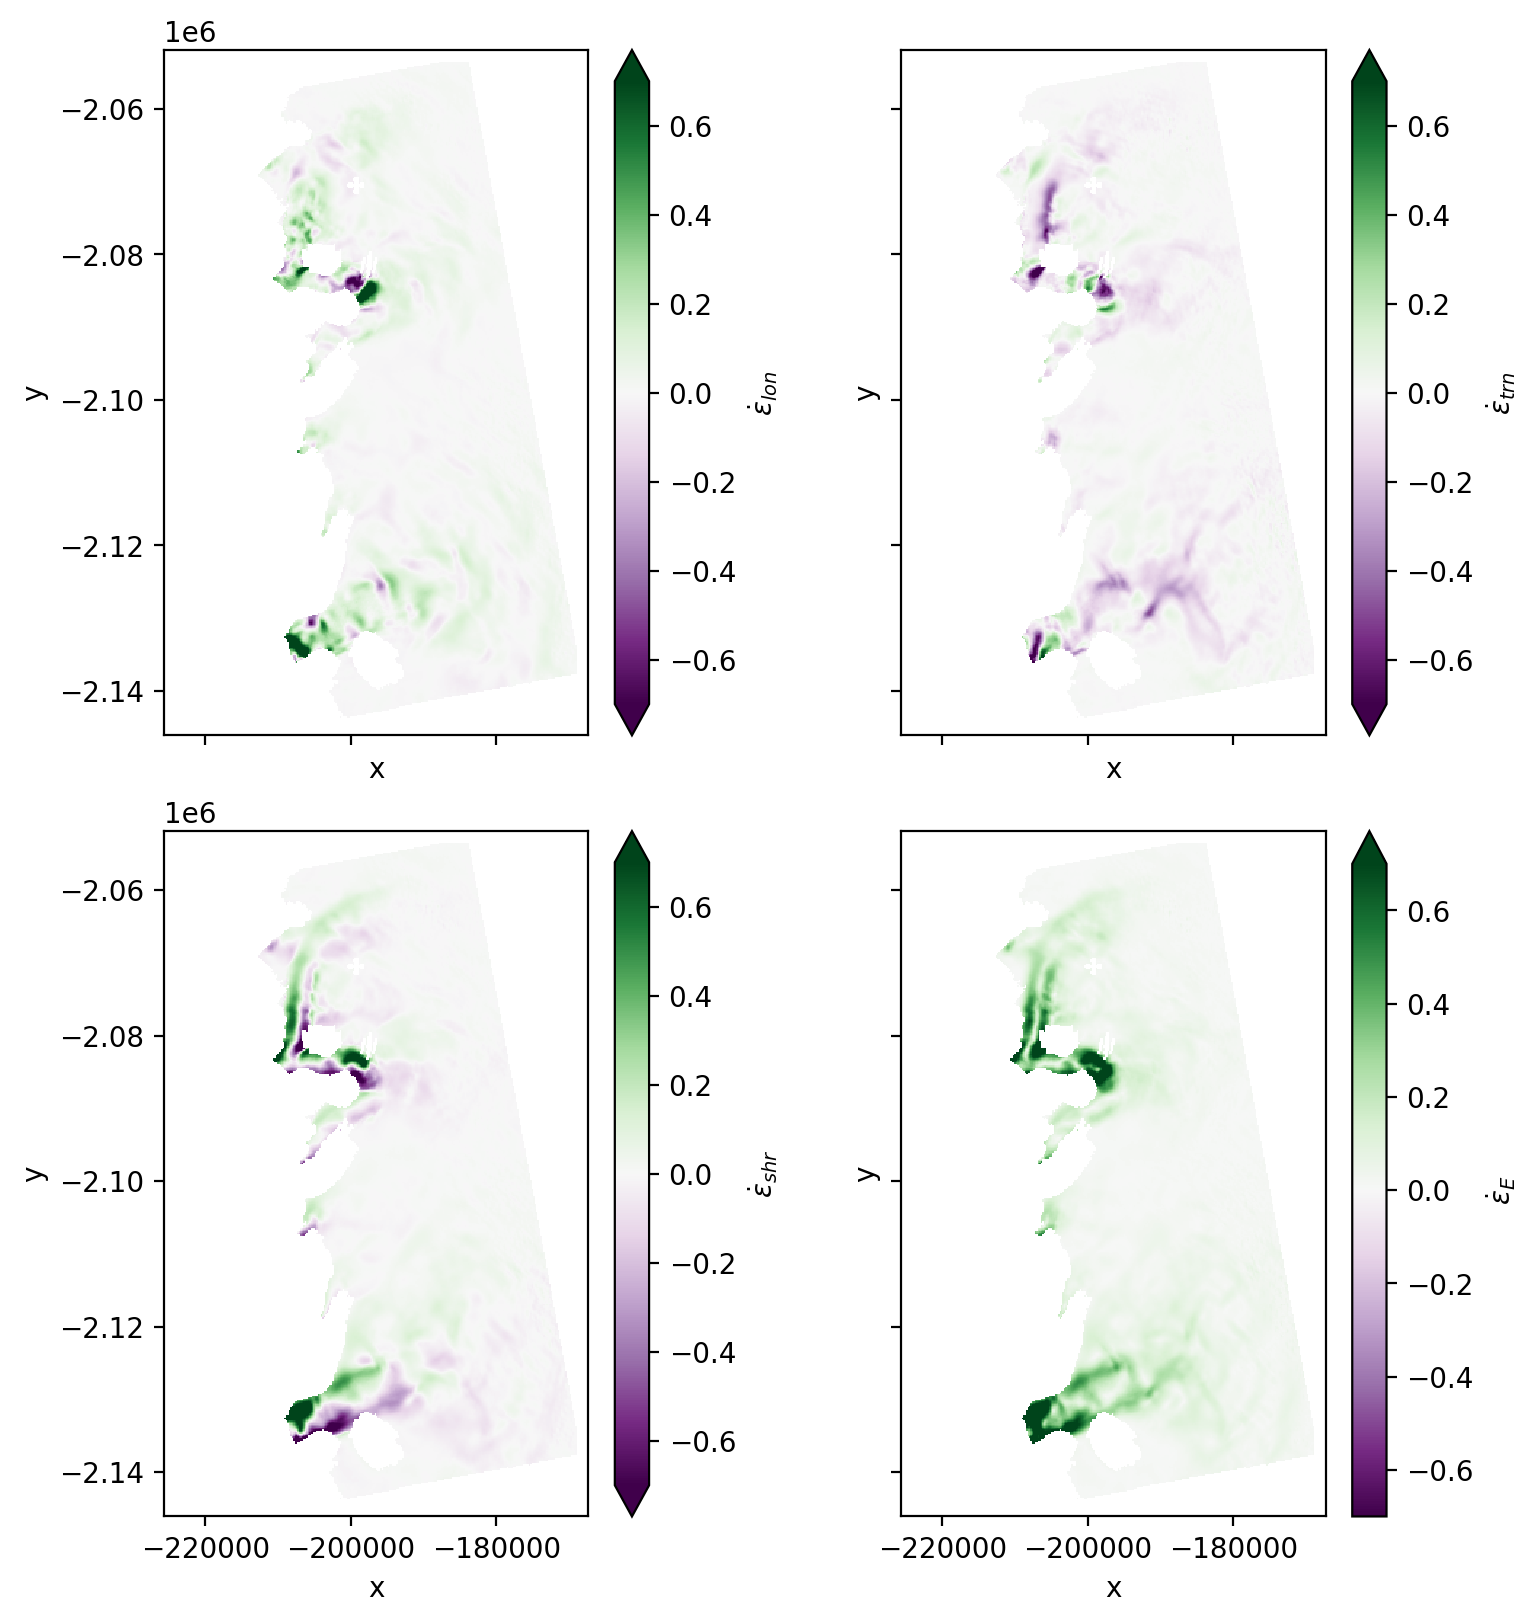

In [13]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7.5,8), sharex=True, sharey=True, layout='constrained')

vmax = 0.7

labels = ("$\dot{\epsilon}_{lon}$", "$\dot{\epsilon}_{trn}$", "$\dot{\epsilon}_{shr}$", "$\dot{\epsilon}_{E}$")

for ax, xds, label in zip(axes.flat, (rotated_strain_rates.e_lon, rotated_strain_rates.e_trn, rotated_strain_rates.e_shr, e_E), labels):
    im = xds.plot(ax=ax, cmap='PRGn', vmin=-vmax, vmax=vmax, cbar_kwargs={'label': f'{label}'})
    ax.set_title(None)
    ax.set_aspect('equal')


Plotting the _directions_ of the first and second principal strain rates can often be very illuminating. An attractive and illuminating way of doing so is to emulate the principle strain rate visualisations in the [Colgan _et al._ (2016) review paper](https://doi.org/10.1002/2015RG000504) (Figs. 3-8, noting Fig. 6 in particular as a 'gridded' example).

Below shows an example of how to emulate this in Python using matplotlib's `quiver()` plot and torturing some of the arrow options. I have also underlain the 'mean strain' - that is, the average of the first and second principal strain. Here, purple background colours indicate a net compressive region and green net extensional.

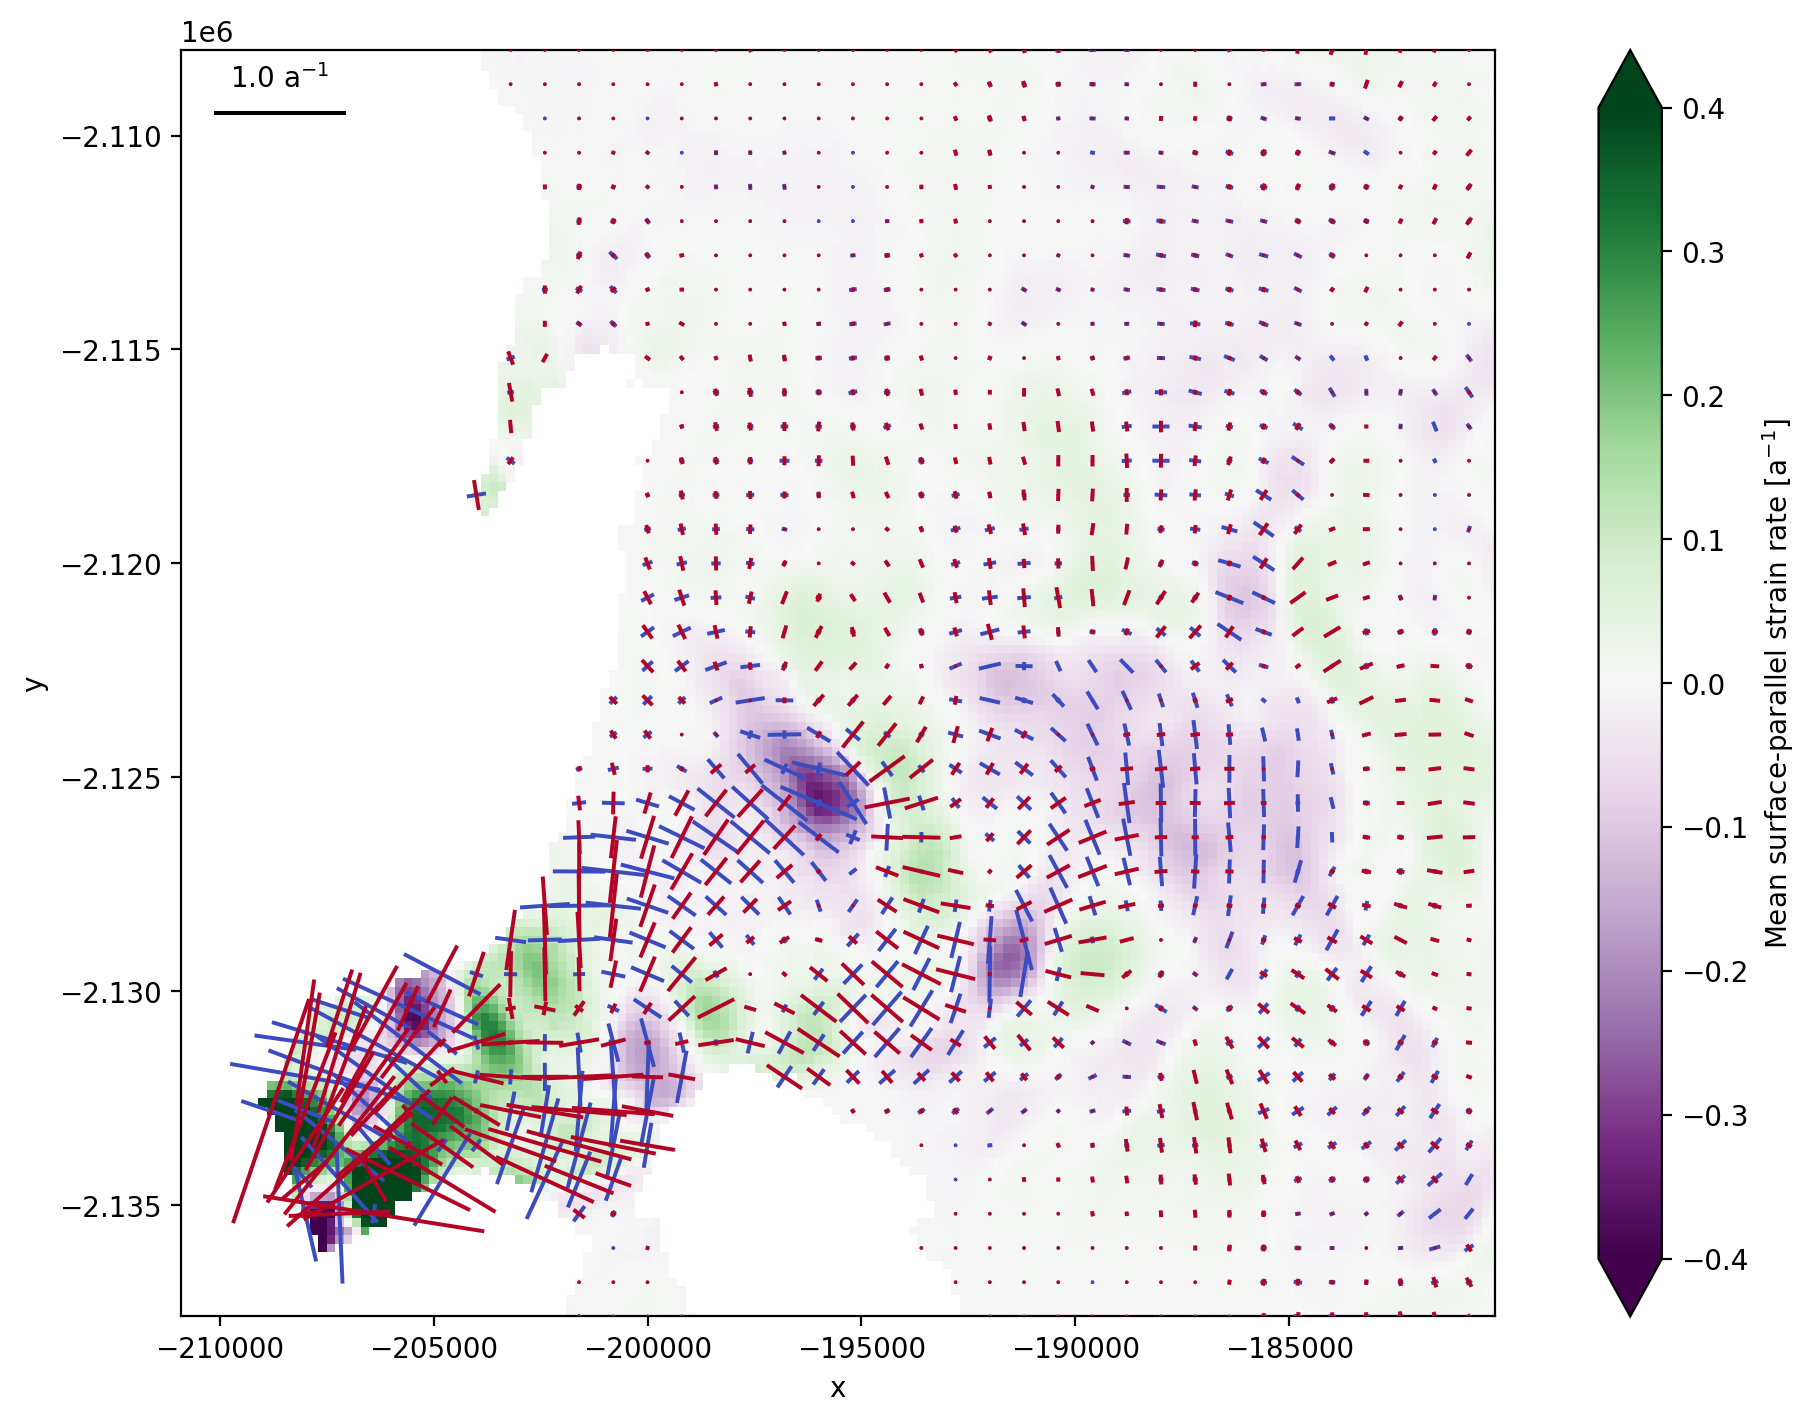

In [14]:

# Broadly appropriate visulation variables for satellite data
vmax = 0.4        # Set colour extent for background image
arrowsize = 0     # Set arrows to zero so as not to visualise
lw = .003         # Line width
arrowscale = 10   # Scale length of arrows. General: 20-30. Inland: 3
show_every = 4    # Show principal strain cross every n grid cells

# Plot every Nth quiver as per https://stackoverflow.com/questions/33576572/python-quiver-options
skip = slice(None, None, show_every)

# Derive binary directions for extensional and compressional quivers (for colouring)
with np.errstate(invalid='ignore'):  # ignore runtime warnings in comparisons against np.nans
    principal_strain_rates['e1colour'] = (('y', 'x'), np.where(principal_strain_rates.e_1 > 0, 1, -1))
    principal_strain_rates['e2colour'] = (('y', 'x'), np.where(principal_strain_rates.e_2 > 0, 1, -1))
    
# Initiate figure
fig, ax = plt.subplots(figsize=(12,7), layout='constrained')

# Plot mean strain
im = e_M.plot(ax=ax, cmap="PRGn", vmin=-vmax, vmax=vmax, cbar_kwargs={'label': "Mean surface-parallel strain rate [$\mathregular{a^{-1}}$]"})

# # Plot second principal strain quivers
e2_qvr = ax.quiver(
    principal_strain_rates.x[skip], 
    principal_strain_rates.y[skip], 
    principal_strain_rates.e_2U[skip, skip],  
    principal_strain_rates.e_2V[skip, skip], 
    principal_strain_rates.e2colour[skip, skip], 
    scale=arrowscale, cmap='coolwarm', clim=(-1, +1),
    pivot='mid', headaxislength=arrowsize, headlength=arrowsize, 
    width=lw, zorder=3
)

# Plot first principal strain quivers
e1_qvr = ax.quiver(
    principal_strain_rates.x[skip], 
    principal_strain_rates.y[skip], 
    principal_strain_rates.e_1U[skip, skip],  
    principal_strain_rates.e_1V[skip, skip], 
    principal_strain_rates.e1colour[skip, skip], 
    scale=arrowscale, cmap='coolwarm', clim=(-1, +1),
    pivot='mid', headaxislength=arrowsize, headlength=arrowsize, 
    width=lw, zorder=3
)

# Plot quiver key
quivlength = arrowscale/10
unit=' $\mathregular{a^{-1}}$'
plt.quiverkey(e1_qvr, X=.075, Y=0.95, U=quivlength, labelpos='N', label=str(quivlength)+unit, color='k', labelcolor='k')

# zoom in
ax.set_xlim(-210900, -180200)
ax.set_ylim(-2137600, -2108000)

# Wrap up
ax.set_title(None)
ax.set_aspect('equal')
